# Problem z pakowaniem pojemników  z pomocą AG
(Bin packing problem)

<p align="center">
  <img width="660" height="300" src="https://scipbook.readthedocs.io/en/latest/_images/bpp-instance.png">
</p>

W przypadku problemu pakowania w pojemniki przedmioty o różnej objętości muszą być pakowane w liczbę pojemników, z których każdy ma określoną objętość w sposób minimalizujący liczbę używanych pojemników. 

W teorii złożoności obliczeniowej jest to kombinatoryczny problem <b>NP</b> - trudny.

<p align="center">
  <img width="660" height="300" src="https://scipbook.readthedocs.io/en/latest/_images/bpp-solution.png">
</p>

Spróbujmy rozwiązać ten problem za pomocą <b>Algorytmu Genetycznego</b>.

Jednak przed przystąpieniem do projektu postanowiłem uzupełnić braki wiedzy i kupiłem książkę: ["Genetic Algorithms with Python" by Clinton Sheppard](https://leanpub.com/genetic_algorithms_with_python)

(Jeśli ktoś jest zainteresowany, mogę wysłać książkę jako osobistą wiadomość w formacie .pdf)

# Sekwencja działań algorytmu

Najczęściej działanie algorytmu przebiega następująco:

* Losowana jest pewna populacja <i>początkowa</i>
* Selekcja
* Krzyżowanie
* Mutacja
* Rodzi się drugie (kolejne) pokolenie
* Jeśli znajdziemy wystarczająco dobre rozwiązanie, wybieramy najlepszego osobnika z populacji - jego genotyp to uzyskany <b>wynik</b>.

In [1]:
from collections import Counter # rodzaj słownika, który pozwala policzyć liczbę niezmiennych obiektów

import numpy as np
import matplotlib.pyplot as plot

# Populacja

W dowolnym momencie algorytm genetyczny przechowuje populację osobników - zbiór potencjalnych rozwiązań danego problemu.

In [2]:
n = 100 # liczba przedmiotów, które chcemy zmieścić w kontenerach

In [3]:
v = np.random.random(size = n) # objetości tych przedmiotów
np.round(v, 3)

array([0.857, 0.716, 0.486, 0.826, 0.207, 0.88 , 0.151, 0.954, 0.782,
       0.553, 0.288, 0.192, 0.919, 0.373, 0.341, 0.245, 0.729, 0.68 ,
       0.468, 0.92 , 0.041, 0.861, 0.238, 0.099, 0.34 , 0.087, 0.854,
       0.648, 0.898, 0.036, 0.123, 0.841, 0.861, 0.063, 0.178, 0.577,
       0.307, 0.267, 0.395, 0.595, 0.054, 0.788, 0.895, 0.643, 0.151,
       0.508, 0.662, 0.852, 0.49 , 0.646, 0.821, 0.912, 0.999, 0.853,
       0.628, 0.454, 0.26 , 0.349, 0.348, 0.231, 0.998, 0.506, 0.894,
       0.67 , 0.88 , 0.034, 0.19 , 0.109, 0.145, 0.627, 0.877, 0.176,
       0.345, 0.414, 0.407, 0.601, 0.111, 0.648, 0.405, 0.167, 0.956,
       0.43 , 0.629, 0.169, 0.832, 0.071, 0.99 , 0.75 , 0.462, 0.949,
       0.737, 0.007, 0.08 , 0.81 , 0.296, 0.291, 0.431, 0.487, 0.133,
       0.993])

In [4]:
v_max = 3 # maksymalna objetość każdego kontenera

Stąd mamy obiekty o pewnej objętości $v_i$, $i=1,...,n$ i dowolną liczbę kontenerów, każdy o pojemności <i>v_max</i>.

<i>Jaka jest najmniejsza liczba kontenerów potrzebna, by spakować wszystkie obiekty?</i>

# Rozwiązania w populacji

Reprezentacja załadowania $nr$_$kontenera()$ :
* $[i_1,i_2,\dots,i_n]$,  gdzie $i_k$ oznacza № kontenera, w którym jest obiekt $k$.

In [5]:
def nr_kontenera(): # konfiguracja numerów kontenera
    return np.random.randint(n/3, size=n) # wybrany losowo

print(nr_kontenera())

[ 9  5  0  3 23 18  9 16  0 31 28 16 16 29 14 27  4  1 11  8 27  5 25 20
 22  3 18  9 26 21  5 30 13 21  6  4 22 14 16 11  9 18  1  6  6 26 20 27
 12  9 23 19 15 13 13 32  1 20 14 13 32 18  0 24 15  3  4  8 13 13 10 10
 26 18  6 32 24 23 15  3  9 18 32  5 30 17 21  5 25 17 22  3 22 20 11  6
 12  7 30 30]


# W rozwiązaniu tego problemu pomoże nam ludność całego miasta

In [6]:
population_size = 100000 # populacja początkowa 100000 osobników 

# każda osoba z populacji wybiera własną konfigurację numerów kontenerów 
population = np.array([nr_kontenera() for _ in range(population_size)])
print(population) 

[[14 18 26 ... 29 17 17]
 [31 30 30 ...  5  1 18]
 [ 0 17  8 ... 22  6 22]
 ...
 [ 5 27 22 ... 10  7  1]
 [ 4 16  4 ... 31  3 15]
 [19 20 17 ... 24 22 30]]


Liczymy liczbę użytych kontenerów za pomozą funkcji <b>quantity()</b>

In [7]:
def quantity(nr_kontenera):                
    myDict = Counter(nr_kontenera) # Counter - rodzaj słownika, który pozwala policzyć liczbę niezmiennych obiektów
    return len(myDict) # liczba unikalnych elementów == liczba użytych kontenerów !!!

quantity(population[0]) # Pierwsza osoba z populacji wybrała X kontenery

33

Obliczamy zużytą objętość każdego pojemnika, która została wybrana przez każdą osobę z populacji za pomozą funkcji <b>volume()</b>

In [8]:
def volume(nr_kontenera):  
    ress_final = []    
    ress = []
    for j in range(n):
        nr_kont = nr_kontenera[j]
        summ = 0        
        for u in range(n):
            if nr_kont == nr_kontenera[u]: # jeśli przedmioty należą do jednego pojemnika, sumuje się ich objętość !!!
                summ += v[u]             
        ress.append(summ)
    new_ress = list(set(ress))
    ress_final.append(new_ress)
    return ress_final

Wykorzystana objętość pojemników przez pierwszą osobę:

In [9]:
alll = volume(population[0])
NEW_alll = alll[0]
NEW_alll # liczba elementów NEW_alll == liczba użytych kontenerów !!!

[0.7162042292523133,
 0.48613044558412877,
 0.6095238490288041,
 3.405680271117709,
 1.3039182975204107,
 3.057864479930971,
 0.6185776122655683,
 0.9542457873230427,
 3.6329589281737094,
 2.202155683561486,
 2.2942544837093797,
 3.1882915243559715,
 2.6143166619240965,
 2.23882819107944,
 0.8337101579996117,
 1.1227294249895707,
 1.0689167601816512,
 0.9938311437803395,
 1.5698083708210138,
 0.8535803854479066,
 2.872483836045844,
 0.2557236602400874,
 1.541774640370604,
 1.9742567057436464,
 1.4430413449621533,
 1.573909153617133,
 0.8260471973461897,
 0.8099514610180499,
 2.4947054184463755,
 2.5864074850981438,
 0.5180636046685299,
 0.03644009505023671,
 0.430309128817834]

Do tablicy <b>numerów</b> dodajemy <b>liczbę</b> użytych kontenerów :

In [46]:
nr_count = [[nr_kontenera, quantity(nr_kontenera)] for nr_kontenera in population]
# nr_count

Sortowanie według liczby zużytych pojemników (rosnąco):

In [11]:
sort = sorted(nr_count, key=lambda x: x[1]) 
#sort

#można uruchomić i zobaczyć, jaki jest wynik

# Selekcja

Po obliczeniu sprawności wszystkich osobników w populacji rozpoczyna się proces <b>selekcji</b>, który określa, które osobniki zostaną pozostawione do <b>reprodukcji</b>, czyli stworzenie potomstwa, które będzie stanowić następne pokolenie.

In [39]:
def selection(popu, n_best):
    sel = []
    k = 0
    com = [[nr_kontenera, quantity(nr_kontenera)] for nr_kontenera in popu]
    popu_c = sorted(nr_count, key=lambda x: x[1])
    p_c = [x[0] for x in popu_c]
    for i in range(len(population)):
        wynik = all(item <= v_max for item in volume(p_c[i])[0])
        if wynik == True:
            k += 1
            sel=np.append(sel,p_c[i])        
        #print(wynik, p_c[i])
        sel=np.reshape(sel,[k,n])
        if k==n_best:
            break
    return sel.astype(np.int) 

In [40]:
# test
population2=selection(population,3) # wybranie 3 najlepszych
print(population2)

[[31 32 31 22 23 23 10 30 13  6 11 22  5 24 11  9  9 17  6 10 24 16 19 28
  20  4  0 22  5 29 27 29 13  4 19 16 19 10 23 11 28 26 24  2 18 15  6 15
  20 27  3  5 16 13  1 11 17 24 18 19  7  0 17 32  2  3  4 13 19  4  2 10
  30  6  9 31 20  1 32  4 29  2 23 19 32 28  3 28 17 22 26 19 30 18 11 18
   3  3 26  0]
 [23 27  1 30 23 21  0 18  7 15  7 11 32 10  1  2 22 24  0  7 31 31  4 28
  27 11 16 29 15 22 30  3  3 24 17 27 25 19  3 17  7 22  9 23  6 17 26  6
   1 10 16 26 29 18  4  4 30  6  0 24 19 28 24  5 31  2 28 26 22  1 17 22
   5 31 18 30  3  2  6 19 28 17 16 16  7 17  2 27  5 26 31 17 10 11 30  9
   4 32 22 23]
 [16  7 20 19 18  2  9  3 11 14  8 17 21 25  7 25 27 16 15 26  7  7 30 14
   6  3  2 30 22 26 21  2 18  0 22 17 32 27 25  0  8 19  1 16 14 14  7  8
  25 17 23  1 17 25 15 32  7 17 21  8 26  9 31 23 14  0 15  6  6 10 15 24
  21 15 25 24  7 21 19 14 28 32  6 11  0 16 26 12 20 24  6 21  9 30  0 31
  21 23 10 27]]


Następnie tworzymy tabelę składającą się z 3 elementów:
* Numer kontenera 
* Liczba używanych kontenerów
* Użyta objętość każdego pojemnika

In [31]:
nr_quantity_volume = [[nr_kontenera, quantity(nr_kontenera), volume(nr_kontenera)] for nr_kontenera in population2]
# nr_quantity_volume

# można uruchomić i zobaczyć, jaki jest wynik

# Mutacja

Celem operatora mutacji jest okresowa, losowa aktualizacja populacji, to znaczy wprowadzenie nowych kombinacji genów do chromosomów, stymulując tym samym poszukiwania w niezbadanych obszarach przestrzeni rozwiązań.

In [32]:
def mutation(nr_kontenera, probability): # nr_kontenera - osobnik, p - prawdopodobieństwo zajścia mutacji 
    if np.random.random() < probability:
        ind1=np.random.randint(n) 
        ind2=np.random.randint(n) 
#        print(ind)
        nr_kontenera[ind1]=nr_kontenera[ind2] 
    return nr_kontenera

In [33]:
print(population2[0])

[31 32 31 22 23 23 10 30 13  6 11 22  5 24 11  9  9 17  6 10 24 16 19 28
 20  4  0 22  5 29 27 29 13  4 19 16 19 10 23 11 28 26 24  2 18 15  6 15
 20 27  3  5 16 13  1 11 17 24 18 19  7  0 17 32  2  3  4 13 19  4  2 10
 30  6  9 31 20  1 32  4 29  2 23 19 32 28  3 28 17 22 26 19 30 18 11 18
  3  3 26  0]


Wynik uzyskany po <i>mutacji</i> losowej :

In [34]:
print(mutation(population2[0], 0.8)) # prawdopodobieństwo mutacji = 0.8

[31 32 31 22 23 23 10 30 13  6 11 22  5 24 11  9  9 17  6 10 24 16 19 28
 20 19  0 22  5 29 27 29 13  4 19 16 19 10 23 11 28 26 24  2 18 15  6 15
 20 27  3  5 16 13  1 11 17 24 18 19  7  0 17 32  2  3  4 13 19  4  2 10
 30  6  9 31 20  1 32  4 29  2 23 19 32 28  3 28 17 22 26 19 30 18 11 18
  3  3 26  0]


# Krzyżowanie

Aby stworzyć parę nowych osobników, zazwyczaj wybiera się rodziców z obecnego pokolenia, a części ich chromosomów są zamieniane (krzyżowane), w wyniku czego powstają dwa nowe chromosomy reprezentujące potomstwo.

In [35]:
def crossover(father, mother): # dwoje rodziców
    cut=np.random.randint(1,n) # losowe miejsce przecięcia chromosomu 
    chp=np.delete(father, np.arange(cut, n, 1))
    chm=np.delete(mother, np.arange(0,cut, 1))
    child=np.concatenate((chp,chm),axis=0) # dziecko
    mutation(child, 0.8) # losowa mutacja
    return child # dziecko (potomstwo)

## Czas stworzyć dynastię

In [36]:
n_children = 3*population_size # liczebność dzieci

In [37]:
def generation():      
    children=np.array([crossover(population[np.random.randint(0,population_size)],\
                             population[np.random.randint(0,population_size)]) for _ in range(n_children)])
                                  
    family = np.concatenate((population,children)) # dodanie dzieci do populacji rodziców

    return selection(family, population_size)

Narodziny kolejnych X pokoleń, których rozwiązania są unikalne.
Wybieramy tylko to, co najlepsze w każdym pokoleniu.

In [41]:
#for _ in range(10):
population3 = generation()
#print(population3)

Uczyńmy nazwy zmiennych w bardziej reprezentatywnej formie

In [42]:
final_volume = [volume(population3[0]) for _ in volume(population3[0])]
quant = quantity(population3[0]) # Minimalna liczba używanych kontenerów

final_volume2 = [] 
for i in range(quant):
    final_volume2.append(final_volume[0][0][i]) # Używana objętość każdego pojemnika    

In [43]:
print('\nMinimalna liczba używanych kontenerów: ', quant)

#print('\nUżywana objętość każdego pojemnika, nie przekraczająca dopuszczalnej:')
#final_volume2


Minimalna liczba używanych kontenerów:  28


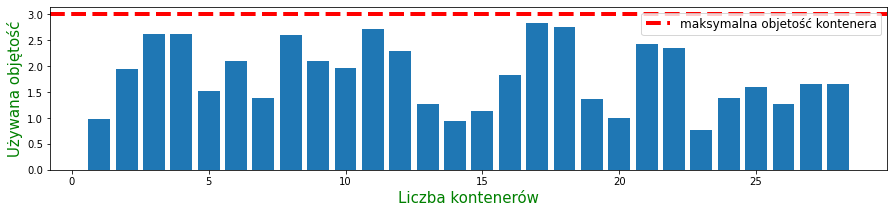

In [44]:
plot.figure(figsize=(15, 3))
x = np.arange(quant) # Liczba używanych kontenerów
plot.bar(x+1, height = final_volume2)

# rysowanie linii poziomej == maksymalna objetość każdego kontenera
plot.axhline(y = v_max, color = 'r', linewidth=4, linestyle = '--', label='maksymalna objetość kontenera')  

plot.xlabel('Liczba kontenerów', fontsize=15, color='green')
plot.ylabel('Używana objętość', fontsize=15, color='green')

#plt.grid()
plot.legend(fontsize=12)
plot.show()

# Wniosek

Korzystając z Algorytmu Genetycznego, staraliśmy znaleźć minimalną liczbę pojemników wymaganych do spakowania wszystkich przedmiotów (mniej niż $1/3$ ogólnej liczby). Istnieje jednak duże prawdopodobieństwo, że to rozwiązanie nie jest najbardziej optymalne (jak widać na wykresie, <i>nie wszystkie</i> słupki osiągają maksimum.). Ale w przypadku problemów ze złożonością kombinatoryczną NP, takie podejście jest całkiem uzasadnione.

# Źródła inspiracji:

* <b>Materiał</b> z Wykładu cz. II i IV (Algorytmy ewolucyjne)
* <b>Genetic Algorithms with Python</b> by Clinton Sheppard
* <b>Hands-On Genetic Algorithms with Python</b> by Eyal Wirsansky